* [Import libs](#libs)
* [Data exploration](#explore-data)
* [Global variables](#global-vars)
* [Data preprocesssing](#data-prep)
* [Extract sentences and labels](#extract)
* [Train-validation split](#train-val-split)
* [Tokenize sentences](#tokenizer)
* [Padding sequences](#padding)
* [Training](#model)
    * [Keras Tuner](#tuner)
    * [Best model](#best-model)
    * [Test data prediction](#test-predict)

<a id='libs'></a>
## Import libs

In [465]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, MaxPooling1D, Dropout, Bidirectional, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import keras_tuner

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<a id="explore-data"></a>
## Data exploration 


In [388]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [247]:
def show_data_wordcloud(data):
    disaster = ' '.join(data[data['target']==1]['text'])
    non_disaster =''.join(data[data['target']==0]['text'])
    
    # show disaster wordcloud
    plt.figure(figsize=(14,6))
    wordcloud = WordCloud(width=1000,height=500).generate(disaster)
    plt.imshow(wordcloud,interpolation='bilinear',cmap='magma')
    plt.axis('off')
    plt.tight_layout()
    plt.title('Disaster Wordcloud',fontsize= 25,color='Red')
    plt.show()
    
    # show non disaster wordcloud
    plt.figure(figsize=(14,6),frameon=True)
    wordcloud = WordCloud(width=800,height=400).generate(non_disaster)
    plt.imshow(wordcloud,interpolation='bilinear',cmap='Dark2')
    plt.axis('off')
    plt.tight_layout()
    plt.title('Non-Disaster Wordcloud',fontsize= 25,color='Black')
    plt.show()

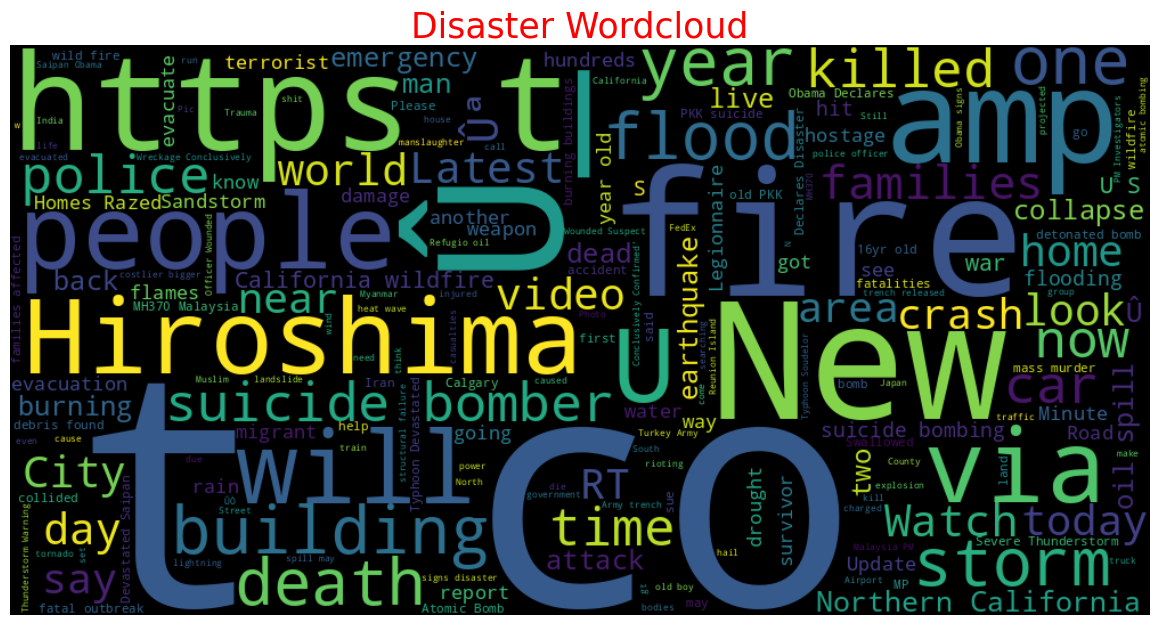

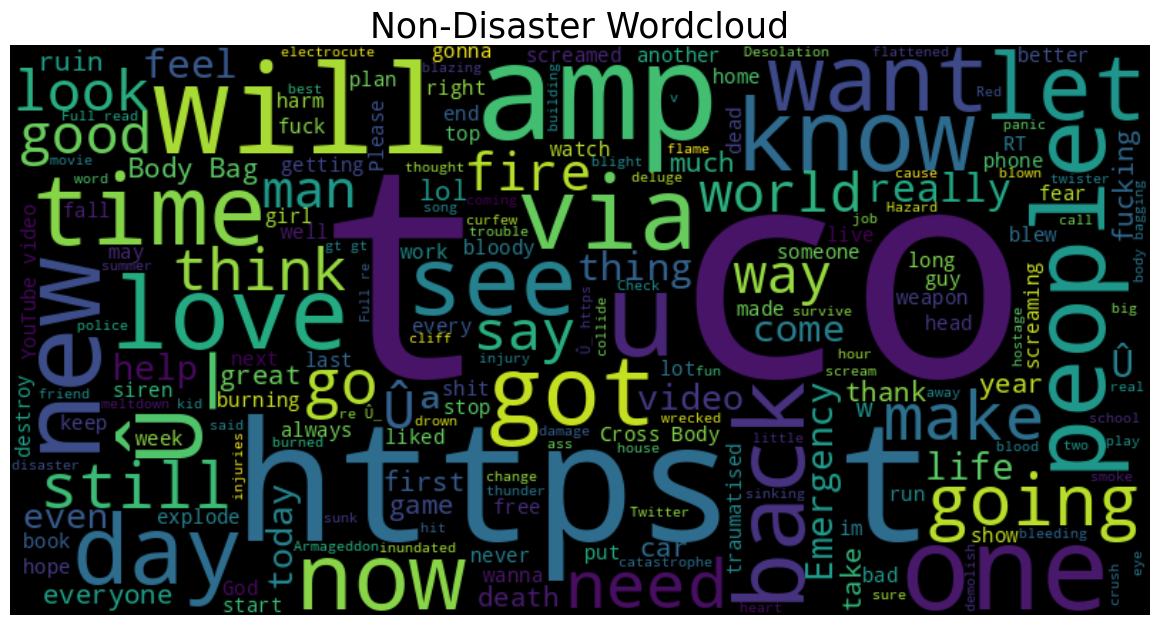

In [248]:
show_data_wordcloud(train_df)

<a id='global-vars'></a>
## Global variables

In [432]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
PADDING = 'post'
MAXLEN = 24
OOV_TOKEN = "<OOV>"
VALIDATION_SIZE = 0.2
STOPWORDS = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "new", "will", "amp", "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "im", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "u" ]
BATCH_SIZE=64,
EPOCHS=30

<a id='data-prep'></a>
## Data preprocessing

We can improve our data to make the following transformation with our texts:
* remove stopwords
* remove numbers, emojis, urls, mentions, punctuations

### Removing stopwords

In [370]:
def remove_stopwords(sentence, stopwords):
    # convert sentence to lower-case
    sentence = sentence.lower()
    
    sentence_words = sentence.split()
    resultWords = [word for word in sentence_words if word not in stopwords]
    
    sentence = ' '.join(resultWords)
    
    return sentence

In [560]:
# test remove_stopwords function
remove_stopwords("I am excited to participate in this competition", STOPWORDS)

'excited participate competition'

### Removing url

In [260]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

### Removing mentions

In [261]:
def remove_mentions(text):
    return re.sub('@\S+', '', text)  

### Removing emojis

In [262]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

### Removing numbers

In [263]:
def remove_nums(text):
    return re.sub(r'[0-9]', '', text)

### Remove punctuations

In [264]:
def remove_punct(text):
    return re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  

### Final preprocessing stage

In [414]:
def preprocess_sentence(sentence):
    sentence = remove_stopwords(sentence, STOPWORDS)
    sentence = remove_url(sentence)
    sentence = remove_mentions(sentence)
    sentence = remove_emoji(sentence)
    sentence = remove_nums(sentence)
    sentence = remove_punct(sentence)
    
    return sentence
    

In [407]:
# testing preprocess_sentence function
test_sent = "https://www.test.com 1-20, new Im @test testing string!? Disaster Tweets."
print(preprocess_sentence(test_sent))

   testing string disaster tweets


In [415]:
train_df['text'] = train_df['text'].apply(preprocess_sentence)
test_df['text'] = test_df['text'].apply(preprocess_sentence)

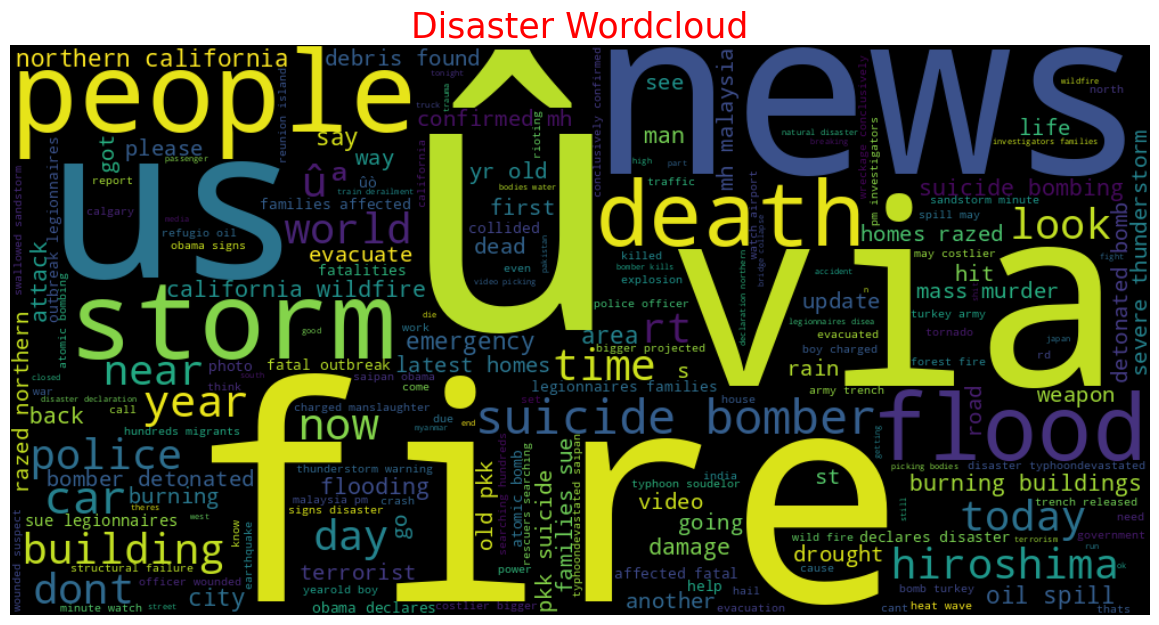

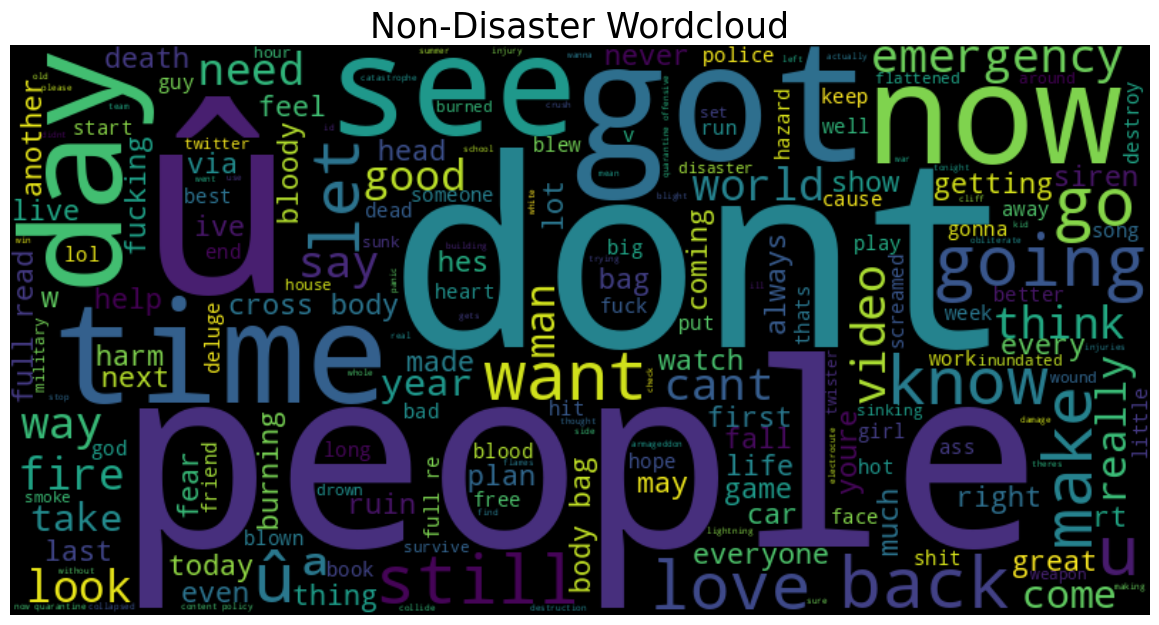

In [416]:
show_data_wordcloud(train_df)

<a id='extract'></a>
## Extract sentences and labels

In [417]:
# train data
sentences = train_df['text'].to_numpy()
print(f'Train data shape: {sentences.shape} sentences')

labels = train_df['target'].to_numpy()
print(f'Train labels shape: {labels.shape}')


Train data shape: (7613,) sentences
Train labels shape: (7613,)


In [418]:
# test data
test_sentences = test_df['text'].to_numpy()
print(f'Test data shape: {test_sentences.shape} sentences')

Test data shape: (3263,) sentences


<a id='train-val-split'></a>
## Train-validation split

In [419]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=VALIDATION_SIZE, random_state=42, stratify=labels)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 6090 sentences for training.

There are 6090 labels for training.

There are 1523 sentences for validation.

There are 1523 labels for validation.


<a id='tokenizer'></a>
## Tokenize sentences

Tokenize sentences using keras Tokenizer.

In [380]:
def fit_tokenizer(sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer

In [433]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 13127 words

<OOV> token included in vocabulary


<a id='padding'></a>
## Padding sequences

**Generates an array of token sequences and pads them to the same length**

In [436]:
def get_padding_sequences(tokenizer, sentences, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [437]:
# train data
train_padded_seq = get_padding_sequences(tokenizer, train_sentences, PADDING, MAXLEN)

print(f"First sentences: {train_sentences[0]}")
print(f"First padded sequence looks like this: \n\n{train_padded_seq[0]}\n")
print(f"Numpy array of train sequences has shape: {train_padded_seq.shape}\n")
print(f"This means there are {train_padded_seq.shape[0]} sequences in total and each one has a size of {train_padded_seq.shape[1]}")

# validation
val_padded_seq = get_padding_sequences(tokenizer, val_sentences, PADDING, MAXLEN)
print(f"Numpy array of validation sequences has shape: {val_padded_seq.shape}\n")

First sentences: sassy city girl country hunk stranded smoky mountain snowstorm aoms ibooklove bookboost
First padded sequence looks like this: 

[  1  97 232 705   1   1   1 909 566   1   1   1   0   0   0   0   0   0
   0   0   0   0   0   0]

Numpy array of train sequences has shape: (6090, 24)

This means there are 6090 sequences in total and each one has a size of 24
Numpy array of validation sequences has shape: (1523, 24)



<a id='model'></a>
## Training model

In [480]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [481]:
vocab_size=len(tokenizer.word_index) + 1
maxlen=train_padded_seq.shape[1]
print(f'Vocabulary size: {vocab_size}')
print(f'Maxlen: {maxlen}')


Vocabulary size: 13128
Maxlen: 24


<a id='tuner'></a>
### Keras Tuner

In [540]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Int("embedding_dim", min_value=16, max_value=64, step=16), input_length=maxlen))
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
        
    if hp.Boolean("conv"):
        model.add(Conv1D(64, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        
    model.add(Bidirectional(LSTM(units=hp.Int("lstm_units", min_value=32, max_value=64, step=32),
                                 return_sequences=True,
                                 kernel_regularizer=regularizers.L2(hp.Float("lr_lstm_1", min_value=1e-4, max_value=1e-2, sampling="log"))))),
    
    model.add(Bidirectional(LSTM(units=hp.Int("lstm_units", min_value=16, max_value=32, step=16),
                                 kernel_regularizer=regularizers.L2(hp.Float("lr_lstm_2", min_value=1e-4, max_value=1e-2, sampling="log"))))),
    
    model.add(Dense(units=hp.Int("dense_units", min_value=32, max_value=512, step=32),
                    activation="relu",
                    kernel_regularizer=regularizers.L2(hp.Float("lr_dense", min_value=1e-4, max_value=1e-2, sampling="log"))))
    
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"],
    )
    
    return model

In [541]:
def tuner_search(X_train, y_train, validation_data):
    tuner = keras_tuner.RandomSearch(
        build_model,
        objective="val_accuracy",
        max_trials=20,
        overwrite=True,
        directory="my_dir",
        project_name="tune_hypermodel",
    )


    tuner.search(X_train, y_train, validation_data = validation_data, epochs=30, callbacks=[EarlyStopping('val_loss', patience=3)])
    
    return tuner

In [542]:
tuner = tuner_search(train_padded_seq, train_labels, validation_data=(val_padded_seq, val_labels))

Trial 20 Complete [00h 00m 54s]
val_accuracy: 0.8030203580856323

Best val_accuracy So Far: 0.8069599270820618
Total elapsed time: 00h 18m 35s


In [543]:
tuner.results_summary()

Results summary
Results in my_dir/tune_hypermodel
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
embedding_dim: 64
dropout: True
conv: True
lstm_units: 64
lr_lstm_1: 0.00011606778136087197
lr_lstm_2: 0.00035246987335309373
dense_units: 32
lr_dense: 0.00010007891408507613
Score: 0.8069599270820618

Trial 04 summary
Hyperparameters:
embedding_dim: 48
dropout: True
conv: False
lstm_units: 32
lr_lstm_1: 0.00013995710682620886
lr_lstm_2: 0.00010151607913684836
dense_units: 96
lr_dense: 0.00012371045236790563
Score: 0.803676962852478

Trial 12 summary
Hyperparameters:
embedding_dim: 16
dropout: True
conv: True
lstm_units: 32
lr_lstm_1: 0.0006523090233677368
lr_lstm_2: 0.0005178710913050513
dense_units: 320
lr_dense: 0.003243375670895756
Score: 0.803676962852478

Trial 19 summary
Hyperparameters:
embedding_dim: 48
dropout: False
conv: True
lstm_units: 64
lr_lstm_1: 0.0005044272742055695
lr_lstm_2: 0.0076208407593745765
dense_units: 44

<a id='best-model'></a>
### Best model

The best model I've trained has the following hyperparameters:
* embedding_dim: 64
* dropout: True
* conv: True
* lstm_units: 64
* lr_lstm_1: 0.00011606778136087197
* lr_lstm_2: 0.00035246987335309373
* dense_units: 32
* lr_dense: 0.00010007891408507613
* Score: 0.8069599270820618


In [545]:
best_model = models = tuner.get_best_models(num_models=2)[0]

In [546]:
best_model.save("best_model_disaster_tweets.keras")

<a id='test-predict'></a>
### Test data prediction

In [548]:
# prepare test data
test_sentences = test_df['text']
encoded_test_text = tokenizer.texts_to_sequences(test_sentences)
padded_test_text = pad_sequences(encoded_test_text, maxlen=maxlen, padding=PADDING)

In [559]:
# predict
predictions = best_model.predict(padded_test_text)

102/102 [==============================] - 1s 7ms/step


In [551]:
binary_pred = (predictions > 0.5).astype(int)

ids = test_df['id']

In [552]:
# Save predictions to CSV file
submission_df = pd.DataFrame({'id': ids, 'target': binary_pred.flatten()})
submission_df.to_csv('submission.csv', index=False)